# The Canonical HANK Model & Fiscal Policy

Authors (by last name): Sophia Cho, Ibrahima Diagne, and Anchi (Bryant) Xia

We illustrate the functionality of our Julia SSJ package by running the cannonical HANK model from Tutorial 1 of the workshop in this notebook.

The first step is to import the packages we'll need.

In [1]:
using PyPlot
include("het.jl")
include("graph.jl");

## Building the Model

- We first define the blocks in the DAG representation of our model. You can find the representation on page 18 of the [Lecture 4 slides here.](https://github.com/shade-econ/nber-workshop-2023/blob/f1ca87dd01a69d3cd282f3cffc506a6d61170929/Lectures/Lecture%204%20Canonical%20HANK%20handout.pdf)

In [2]:
# Specify the inputs (ins) and outputs (outs) of each block. This dictionary contains the relevant variables we want in our jacobian calculations. 
ins_outs = [
    Dict("ins" => ["r", "G", "B", "Y"], "outs" => ["Z"]), # Fiscal policy block
    Dict("ins" => ["Z", "r"], "outs" => ["A"]), # HA block
    Dict("ins" => ["A", "B"], "outs" => ["asset_mkt"]), # Asset market clearing inputs
    Dict("ins" => ["Y", "C", "G"], "outs" => ["goods_mkt"]), # Goods market clearing inputs
]

4-element Vector{Dict{String, Vector{String}}}:
 Dict("ins" => ["r", "G", "B", "Y"], "outs" => ["Z"])
 Dict("ins" => ["Z", "r"], "outs" => ["A"])
 Dict("ins" => ["A", "B"], "outs" => ["asset_mkt"])
 Dict("ins" => ["Y", "C", "G"], "outs" => ["goods_mkt"])

### 1. Simple Blocks

- These are blocks where a function is performed on a set of inputs, yielding targets (eg. asset_mkt) and intermediary outputs (eg. Z). 
- The constructor is found in Block.jl

In [3]:
# Define the fiscal policy block
dict_in_fiscal = Dict{Any, Any}(
    "B" => 0.8,
    "r" => 0.03,
    "G" => 0.2,
    "Y" => 1.0
)

dict_out_fiscal = Dict{Any, Any}(
    "Z" => nothing
)

function f_fiscal(block::Block)
    B, r, G, Y = block.ins["B"], block.ins["r"], block.ins["G"], block.ins["Y"]
    T = G + r * B
    Z = Y - T
    block.outs["Z"] = Z
end

# Inputs into fiscal block instance are: all inputs to block, all outputs from block, block's function, relevant jac. vars for block, block name
fiscal_block = Block(dict_in_fiscal, dict_out_fiscal, f_fiscal, ins_outs, "Fiscal");

In [4]:
# Define the market clearing block
dict_in_mkt = Dict{Any, Any}(
    "A" => nothing,
    "B" => 0.8,
    "Y" => 1.0,
    "C" => nothing,
    "G" => 0.2
)

dict_out_mkt = Dict{Any, Any}(
    "asset_mkt" => nothing,
    "goods_mkt" => nothing
)

function f_mkt_clearing(block::Block)
    A, B, Y, C, G = block.ins["A"], block.ins["B"], block.ins["Y"], block.ins["C"], block.ins["G"]
    asset_mkt = A - B
    goods_mkt = Y - C - G
    block.outs["asset_mkt"] = asset_mkt
    block.outs["goods_mkt"] = goods_mkt
end

# Inputs into market block instance are: all inputs to block, all outputs from block, block's function, relevant jac. vars for block, block name
mkt_clearing_block = Block(dict_in_mkt, dict_out_mkt, f_mkt_clearing, ins_outs, "Clearing");

### 2. Heterogenous Agent Block

- We then define the Heterogenous Agent/Household block (constructor found in Het.jl)

In [5]:
# Define the household block
hh_block = HH_Block(Dict{Any, Any}("Z" => nothing, "r" => nothing), Dict{Any, Any}("A" => nothing, "C" => nothing), "HA", []); 

### 3. Creating the Model
- We create an instance of the cannonical HANK model using the DAG_Rep constructor. The constructor takes a list of blocks and does topological sort (orders the blocks based on their inputs and outputs). The constructor is found in Graph.jl

In [6]:
c_hank = DAG_Rep([fiscal_block, hh_block, mkt_clearing_block]);

## Calibrating the Model and Finding the Steady State

In [7]:
calibration = Dict("eis" => 0.5,  # Elasticity of intertemporal substitution
                   "rho_e" => 0.9,  # Persistence of idiosyncratic productivity shocks
                   "sd_e" => 0.92,  # Standard deviation of idiosyncratic productivity shocks
                   "G" => 0.2,  # Government spending
                   "B" => 0.8,  # Government debt
                   "Y" => 1.,  # Output
                   "min_a" => 0.,  # Minimum asset level on the grid
                   "max_a" => 1_000,  # Maximum asset level on the grid
                   "n_a" => 200,  # Number of asset grid points
                   "n_e" => 10,  # Number of productivity grid points
                   "r" => 0.03,
                   "beta" => 0.85)
                   
# These are a subset of the calibration that are relevent to the HA block
inputs_to_hh = Dict("eis" => calibration["eis"], 
                    "rho_e" => calibration["rho_e"],
                    "sd_e" => calibration["sd_e"],
                    "n_e" => calibration["n_e"],
                    "min_a" => calibration["min_a"],
                    "max_a" => calibration["max_a"],
                    "n_a" => calibration["n_a"],
                    "r" => calibration["r"],
                    "beta" => calibration["beta"],
                    "eis" => calibration["eis"],
                    "B" => calibration["B"]);

- The "DAG_get_ss" function propagates through the DAG to return steady state values for all inputs and outputs in the model.

In [8]:
# Print steady state values from DAG
ss_vals, hh_ss_all_vals = DAG_get_ss(c_hank, "None", inputs_to_hh)
println(ss_vals)

Dict{Any, Any}("Z" => 0.776, "A" => 0.7999999999999997, "C" => 0.8000000004849723, "goods_mkt" => -4.849723400646155e-10, "asset_mkt" => -3.3306690738754696e-16)


## Computing Impulse Responses while Enforcing G.E.

## Defining Example 1

* Shock to $G$ and $B$ (deficit financed)
* $r$ adjusts for market clearing.
* In short, monetary policy counters fiscal policy to keep output constant.

In [9]:
end_T = 300; # Truncation period

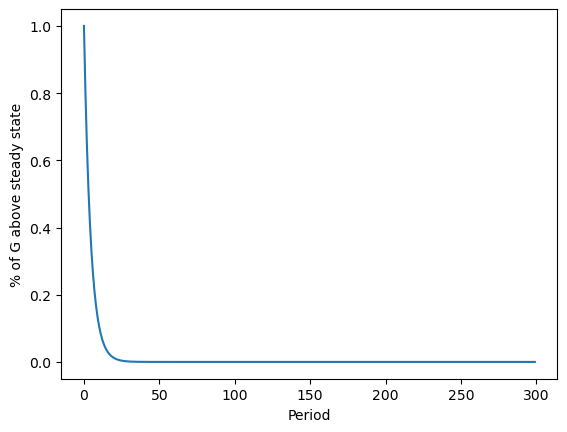

In [10]:
# Fiscal shock with deficit financed
rho_G = 0.8 # Shocking Z is as if we are subtracting from Z directly (equivalent to G increase; need to account for increase elsewhere)
dG = 0.01 * rho_G .^ collect(0:end_T-1)
Gs = fill(0.2, end_T) + dG

rho_B = 0.9
dB = cumsum(dG) .* (rho_B .^ collect(0:end_T-1))
Bs_prev = fill(0.8, end_T)
Bs_prev[2:end] += dB[1:end-1]
Bs = fill(0.8, end_T) + dB

rs_ss = fill(0.03, end_T)

taxes = (1 .+ rs_ss) .* Bs_prev .- Bs .+ Gs
plot(100 .* (Gs .- 0.2))
xlabel("Period")
ylabel("% of G above steady state");

## Using Jacobians to find IRFs

### 1. Use 'ha_jacobian' function to find all jacobians of the HA block

In [11]:
# Returns a dictionary of Jacobians- inputs: steady state values, dictionary of inputs to shock, Y, B, B_prev, G, T (# of periods), no compounding
het_Js_no_compound = ha_jacobian(hh_ss_all_vals, Dict("r" => Dict("r" => 1), "z" => Dict("z" => 1)), 1.0, 0.8, 0.8, 0.2, end_T, false) # Multiplied by h which is 1e-4

Dict{String, Dict{Any, Any}} with 2 entries:
  "A" => Dict("r"=>[0.651714 0.148966 … -2.28187e-13 -2.28908e-13; 0.547047 0.7…
  "C" => Dict("r"=>[0.148286 -0.148966 … 2.28179e-13 2.28899e-13; 0.124219 0.18…

- We then manually load all of the simple block and HA block jacobians into the DAG

Future Changes:
- In the future, one could use numerical differentiation to calculate the jacobians for the simple block, according to Bence.
    - Moreover, when we instantiate the simple blocks, one could automatically append its jacobian to the model's jacobians dictionary

In [13]:
dZ_dB = zeros(end_T, end_T)
for row in 1:end_T
    dZ_dB[row, row] = 1
    if row > 1
        dZ_dB[row, row - 1] = - 1 - hh_ss_all_vals["r"]
    end
end

c_hank.all_Jacobians["∂Z/∂B"] = dZ_dB
c_hank.all_Jacobians["∂Z/∂r"] = -1 * hh_ss_all_vals["A"] .* I
c_hank.all_Jacobians["∂Z/∂Y"] = I
c_hank.all_Jacobians["∂Z/∂G"] = -1 .* I
c_hank.all_Jacobians["∂A/∂Z"] = het_Js_no_compound["A"]["z"]
c_hank.all_Jacobians["∂A/∂r"] = het_Js_no_compound["A"]["r"]
c_hank.all_Jacobians["∂C/∂Z"] = het_Js_no_compound["C"]["z"]
c_hank.all_Jacobians["∂C/∂r"] = het_Js_no_compound["C"]["r"]
c_hank.all_Jacobians["∂Hg/∂Y"] = I
c_hank.all_Jacobians["∂Hg/∂C"] = -1 .* I
c_hank.all_Jacobians["∂Hg/∂G"] = -1 .* I
c_hank.all_Jacobians["∂Ha/∂A"] = I
c_hank.all_Jacobians["∂Ha/∂B"] = -1 .* I;

In [14]:
# Intialize steady state sequences
Ys_ss = fill(1.0, end_T)
no_shock_ss = zeros(end_T, 10)
rs_ss = fill(hh_ss_all_vals["r"], end_T);

This is the maximum error 0.024094531908630867 after iteration 1
This is the maximum error 5.843447019937553e-5 after iteration 2
This is the maximum error 9.759626335981153e-7 after iteration 3
This is the maximum error 2.295880774383363e-8 after iteration 4
This is the maximum error 5.538669523019735e-10 after iteration 5
Asset market clearing up to 12 digits after 6 iterations


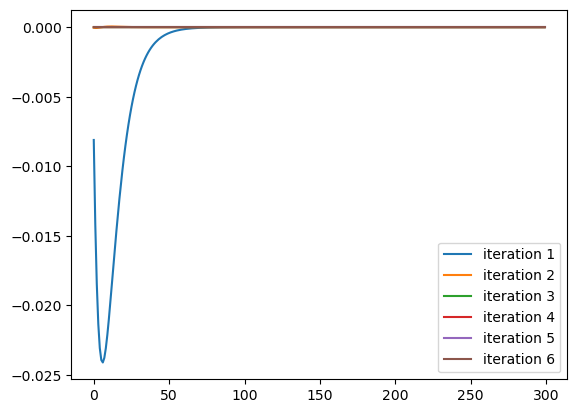

In [15]:
rs = fill(hh_ss_all_vals["r"], end_T)
Jbar = (het_Js_no_compound["A"]["r"] - 0.8 .* het_Js_no_compound["A"]["z"])[1:end-1, 2:end] 
errs = Float64[]
for it in 1:100
    asset_mkt_error, good_mkt_error, impulse = impulse_map(Ys_ss, rs, Bs, Bs_prev, Gs, hh_ss_all_vals, end_T)
    plot(asset_mkt_error, label="iteration $it")
    err = maximum(abs.(asset_mkt_error[1:end-1])) # Solve for asset market clearing at 0, 1, ..., T-2
    push!(errs, err)
    if err < 1E-10
        println("Asset market clearing up to 12 digits after $it iterations")
        break
    end
    rs[2:end] -= Jbar \ asset_mkt_error[1:end-1] # Adjust r_1, ..., r_(T-1)
    println("This is the maximum error $err after iteration $it")
end
legend();

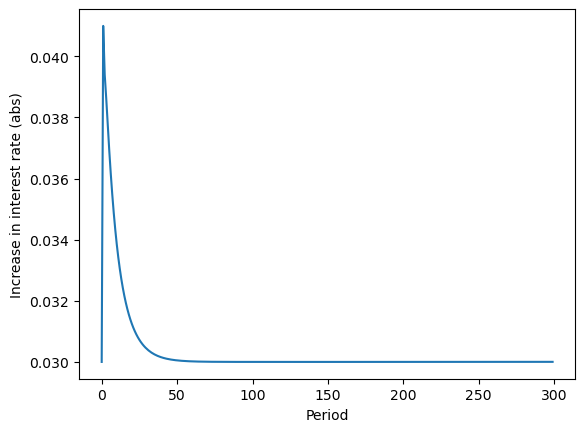

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x117f249a0>

In [31]:
xlabel("Period")
ylabel("Increase in interest rate (abs)")
plot(100 .* (rs .- 0.03));
#plot(rs)

* Interest rate is 0 (compared to ss) since this is carried over from the previous period (we set interest for the next period).
* General shape makes sense.
* We could have used the other Jacobian for this exercise (clearing the goods market instead of the asset market; same by Walras's law).

This is the maximum error 0.008106307959409309 after iteration 1
This is the maximum error 4.36370335988312e-5 after iteration 2
This is the maximum error 9.068211405283133e-6 after iteration 3
This is the maximum error 8.987865762588587e-6 after iteration 4
This is the maximum error 8.017804292714814e-8 after iteration 5
This is the maximum error 1.687581741016686e-10 after iteration 6
Goods market clearing up to 12 digits after 7 iterations


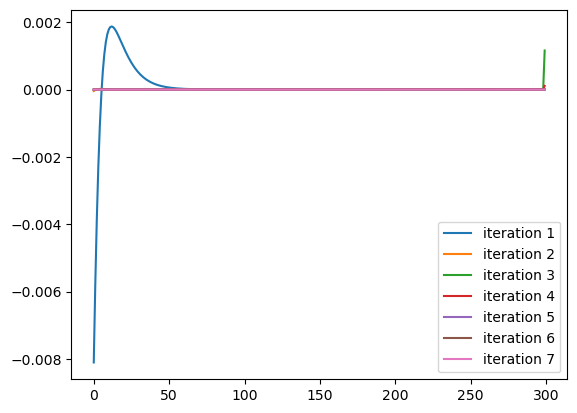

In [17]:
rs = fill(0.03, end_T)
Jbar = (-1 .* het_Js_no_compound["C"]["r"] + 0.8 .* het_Js_no_compound["C"]["z"])[1:end-1, 2:end] # This is w.r.t. to c; the goods market has it reversed
errs = Float64[]
impulse = nothing
asset_mkt_error = nothing
for it in 1:1000
    asset_mkt_error, goods_mkt_error, impulse = impulse_map(Ys_ss, rs, Bs, Bs_prev, Gs, hh_ss_all_vals, end_T)
    plot(goods_mkt_error, label="iteration $it")
    err = maximum(abs.(goods_mkt_error[1:end-1])) # Solve for asset market clearing at 0, 1, ..., T-2
    push!(errs, err)
    if err < 1E-10
        println("Goods market clearing up to 12 digits after $it iterations")
        break
    end
    rs[2:end] -= (Jbar \ goods_mkt_error[1:end-1]) # Adjust r_1, ..., r_(T-1)
    println("This is the maximum error $err after iteration $it")
end
legend();

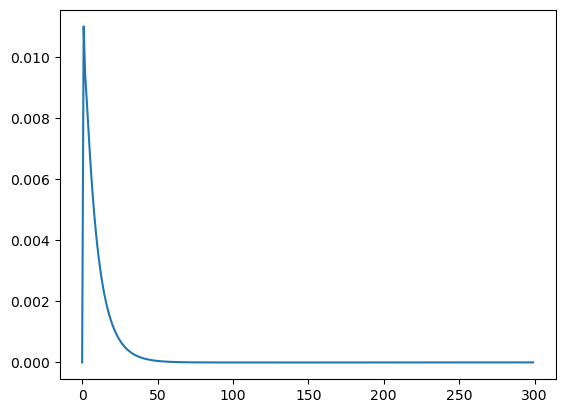

In [18]:
plot(rs .- 0.03);

## Example 2

* We have the same shocks as before.
* We hold $r$ fixed and let $Y$ adjust freely.
* This is the same exercise as the second example in Tutorial 1 of the workshop.

This is the maximum error 0.024094531908630867 after iteration 1
This is the maximum error 7.112085984528616e-5 after iteration 2
This is the maximum error 4.867118731377573e-7 after iteration 3
This is the maximum error 3.2075658795704953e-9 after iteration 4
Asset market clearing up to 12 digits after 5 iterations


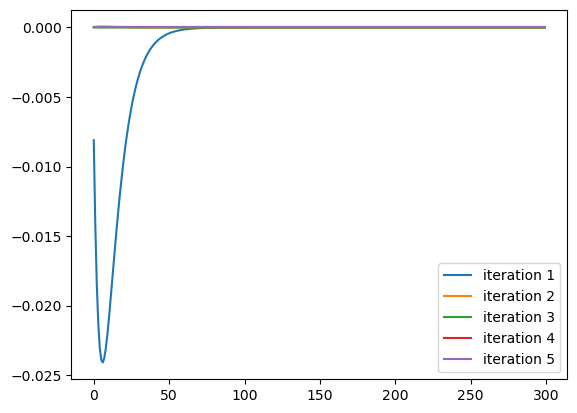

In [19]:
Ys_update = fill(1.0, end_T)
Jbar = het_Js_no_compound["A"]["z"][1:end-1, 1:end-1]
errs = Float64[]
impulse = nothing
asset_mkt_error = nothing
for it in 1:1000
    asset_mkt_error, goods_mkt_error, impulse = impulse_map(Ys_update, rs_ss, Bs, Bs_prev, Gs, hh_ss_all_vals, end_T)
    plot(asset_mkt_error, label="iteration $it")
    err = maximum(abs.(asset_mkt_error[1:end-1])) # Solve for asset market clearing at 0, 1, ..., T-2
    push!(errs, err)
    if err < 1E-10
        println("Asset market clearing up to 12 digits after $it iterations")
        break
    end
    Ys_update[1:end-1] -= (Jbar \ asset_mkt_error[1:end-1]) # Adjust r_1, ..., r_(T-1)
    println("This is the maximum error $err after iteration $it")
end
legend();

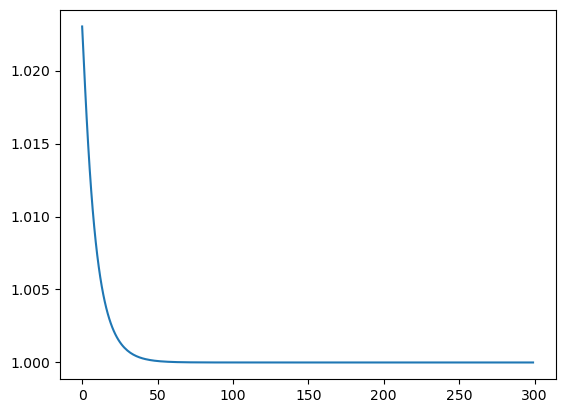

In [20]:
plot(Ys_update);

* Alternatively, we know the asset market clears, so $dA = dB$. It sufficies to invert one Jacobian.

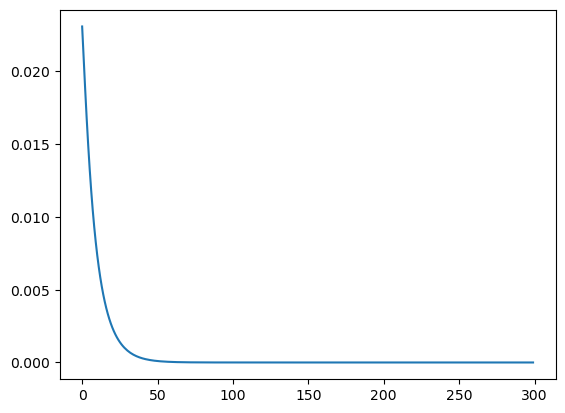

In [21]:
dz = het_Js_no_compound["A"]["z"] \ dB
dY = taxes .- 0.224 + dz
plot(dY);

* The Jacobian from `het_Js["C"]["z"]` computes how consumption responds to income shocks, but is not technically correct when updating with the goods market error (does not account for the effect of -$Y$).
* Using the DAG representation and IFT, we can get the IRF directly without needing to run Newton's algorithm.

* We know $dH = \mathcal J^{H,Y}dY - \mathcal J^{H,C}dC - \mathcal J^{H,G}dG$.
* $B$ impacts $H$ through changing $C$ indirectly; $G$ impacts $H$ through $C$ indirectly and $G$ directly.
* We first solve for the shocks' total effects on $H$.
* We then invert to solve for how $Y$ should respond.

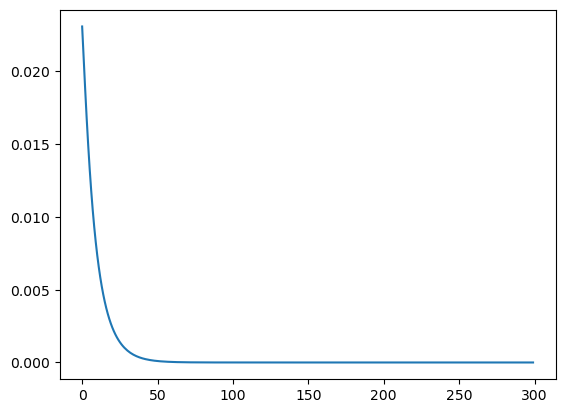

In [22]:
H_G = het_Js_no_compound["C"]["z"] - Matrix(I, end_T, end_T)
H_B = -1 .* het_Js_no_compound["C"]["z"] * dZ_dB
H_Y = Matrix(I, end_T, end_T) - het_Js_no_compound["C"]["z"]

d_other = -1 .* (H_G * dG + H_B * dB)
dY_guess = H_Y \ d_other
plot(dY_guess);

## Testing Forward Accumulation

In the above examples, we calculated total Jacobians (of some target variable with respect to some shock variable) by hand. Alternatively, given a shock variable (svar) and a target variable (tvar), we could find all the svar - tvar paths: the same path enters multiplicatively (chain rule), whereas different paths are additive. Code-wise, this is implemented recursively using DFS and backtracking. One neat thing to note is that because we are working with DAGs, there is no need to keep track of visited nodes, since we will never run into a cycle.

Solving Example 2 using the goods market error:

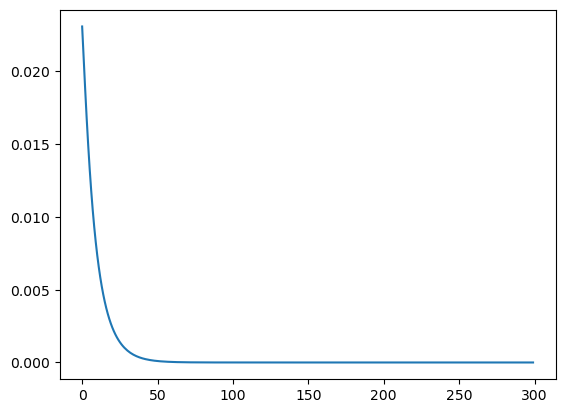

In [23]:
Y_paths = fw_acc(c_hank, "Y", "goods")
B_paths = fw_acc(c_hank, "B", "goods")
G_paths = fw_acc(c_hank, "G", "goods")

Hg_Y, Hg_Y_sym = construct(Y_paths, c_hank.all_Jacobians, end_T)
Hg_G, Hg_G_sym = construct(G_paths, c_hank.all_Jacobians, end_T)
Hg_B, Hg_B_sym = construct(B_paths, c_hank.all_Jacobians, end_T)

dY_auto = H_Y \ (-1 .* Hg_G * dG + -1 .* Hg_B * dB)
plot(dY_auto);

In [24]:
println("Note that the construct function also returns the symbolic representation of the total Jacobian computed. For instance, the total Jacobian of how the goods market changes with respect to Y is $Hg_Y_sym.")

Note that the construct function also returns the symbolic representation of the total Jacobian computed. For instance, the total Jacobian of how the goods market changes with respect to Y is ∂Hg/∂C * ∂C/∂Z * ∂Z/∂Y + ∂Hg/∂Y.


Great, this is the same impulse response we obtained before when we let $Y$ adjust and hold $r$ fixed. Note, we could have also used the asset market error instead. This is done below.

Solving Example 2 using the asset market error:

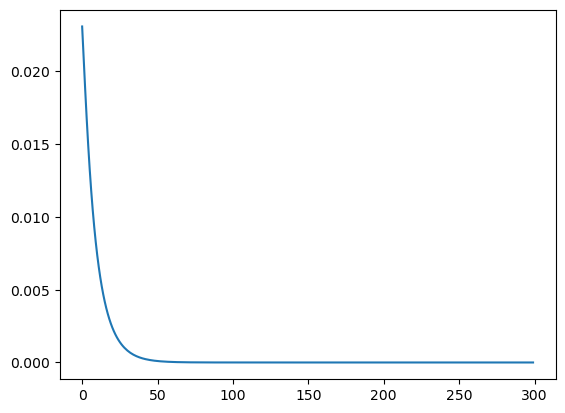

In [25]:
Y_paths = fw_acc(c_hank, "Y", "asset")
B_paths = fw_acc(c_hank, "B", "asset")
G_paths = fw_acc(c_hank, "G", "asset")

Ha_Y, _ = construct(Y_paths, c_hank.all_Jacobians, end_T)
Ha_G, _ = construct(G_paths, c_hank.all_Jacobians, end_T)
Ha_B, _ = construct(B_paths, c_hank.all_Jacobians, end_T)

dY_auto_alt = Ha_Y \ (-1 .* Ha_G * dG + -1 .* Ha_B * dB)
plot(dY_auto_alt);

Now, we let $r$ adjust and hold $Y$ fixed to test the other Jacobians.

Solving Example 1 using the asset market error:

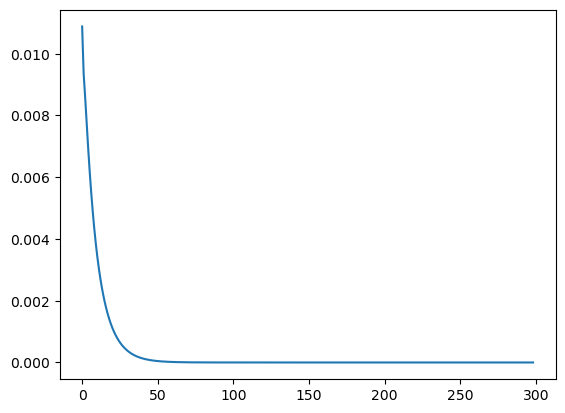

In [28]:
Ha_r, _ = construct(fw_acc(c_hank,"r","asset"), c_hank.all_Jacobians, end_T)
Ha_G, _ = construct(fw_acc(c_hank,"G","asset"), c_hank.all_Jacobians, end_T)
Ha_B, _ = construct(fw_acc(c_hank,"B","asset"), c_hank.all_Jacobians, end_T)

r_auto = Ha_r[1:end-1, 2:end] \ ((-1. * Ha_B * dB - Ha_G * dG)[1:end-1])
plot(r_auto);

Finally, let us use the goods market error instead of the asset market error.

Solving Example 1 using the goods market error:

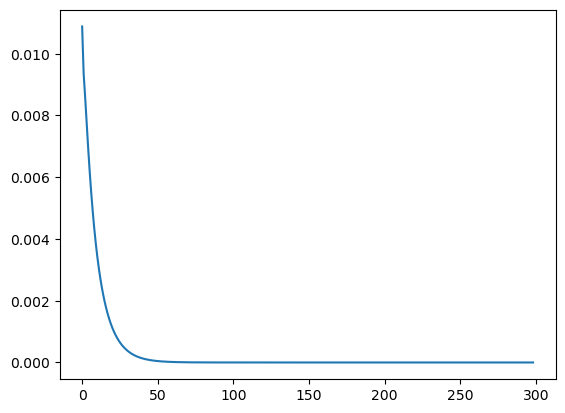

In [29]:
Hg_r, _ = construct(fw_acc(c_hank,"r","goods"), c_hank.all_Jacobians, end_T)
Hg_G, _ = construct(fw_acc(c_hank,"G","goods"), c_hank.all_Jacobians, end_T)
Hg_B, _ = construct(fw_acc(c_hank,"B","goods"), c_hank.all_Jacobians, end_T)

r_auto = Ha_r[1:end-1, 2:end] \ ((-1. * Ha_B * dB - Ha_G * dG)[1:end-1])
plot(r_auto);